In [1]:
import numpy as np
import pandas as pd
import mlxtend as mlx

# examples from: https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c
# https://www.datatheque.com/posts/association-analysis/ ### <- Look here if you want to manually code some of the rules!
# https://pyshark.com/market-basket-analysis-using-association-rule-mining-in-python/

### Reading in the data

In [2]:
df = pd.read_csv('https://gist.githubusercontent.com/Harsh-Git-Hub/2979ec48043928ad9033d8469928e751/raw/72de943e040b8bd0d087624b154d41b2ba9d9b60/retail_dataset.csv', sep=',')

In [3]:
df

,0,1,2,3,4,5,6
0,Bread,Wine,Eggs,Meat,Cheese,Pencil,Diaper
1,Bread,Cheese,Meat,Diaper,Wine,Milk,Pencil
2,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
3,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
4,Meat,Pencil,Wine,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
310,Bread,Eggs,Cheese,NaN,NaN,NaN,NaN
311,Meat,Milk,Pencil,NaN,NaN,NaN,NaN
312,Bread,Cheese,Eggs,Meat,Pencil,Diaper,Wine
313,Meat,Cheese,NaN,NaN,NaN,NaN,NaN


### Quick Look at the data

In [4]:
## Number of unique items:
items = set()
for col in df:
    items.update(df[col].unique())

print(items)

{nan, 'Bread', 'Cheese', 'Pencil', 'Bagel', 'Meat', 'Milk', 'Wine', 'Eggs', 'Diaper'}


#### One hot encoding (the hard way)

In [5]:
itemset = set(items)
encoded_vals = []
for index, row in df.iterrows():
    rowset = set(row) 
    labels = {}
    uncommons = list(itemset - rowset)
    commons = list(itemset.intersection(rowset))
    for uc in uncommons:
        labels[uc] = 0
    for com in commons:
        labels[com] = 1
    encoded_vals.append(labels)
encoded_vals[0]
ohe_df_difficult = pd.DataFrame(encoded_vals)

In [6]:
ohe_df_difficult

,NaN,Bagel,Milk,Bread,Cheese,Pencil,Meat,Wine,Eggs,Diaper
0,0,0,0,1,1,1,1,1,1,1
1,0,0,1,1,1,1,1,1,0,1
2,1,0,1,0,1,0,1,1,1,0
3,1,0,1,0,1,0,1,1,1,0
4,1,0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
310,1,0,0,1,1,0,0,0,1,0
311,1,0,1,0,0,1,1,0,0,0
312,0,0,0,1,1,1,1,1,1,1
313,1,0,0,0,1,0,1,0,0,0


###### Note at this point you have to drop the "NaN" column too!

#### One hot encoding (the read-the-docs way)

In [7]:
from mlxtend.preprocessing import TransactionEncoder

te = mlx.preprocessing.TransactionEncoder()

a = [[y for y in x if pd.notna(y)] for x in df.values.tolist()]
te_array = te.fit(a).transform(a)
ohe_df= pd.DataFrame(te_array, columns=te.columns_)

In [8]:
ohe_df

,Bagel,Bread,Cheese,Diaper,Eggs,Meat,Milk,Pencil,Wine
0,False,True,True,True,True,True,False,True,True
1,False,True,True,True,False,True,True,True,True
2,False,False,True,False,True,True,True,False,True
3,False,False,True,False,True,True,True,False,True
4,False,False,False,False,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...
310,False,True,True,False,True,False,False,False,False
311,False,False,False,False,False,True,True,True,False
312,False,True,True,True,True,True,False,True,True
313,False,False,True,False,False,True,False,False,False


### Getting all item-sets with enough support

In [9]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets_ap = mlx.frequent_patterns.apriori(ohe_df, min_support=.05, use_colnames=True)
frequent_itemsets_fp=mlx.frequent_patterns.fpgrowth(ohe_df, min_support=0.05, use_colnames=True)

In [10]:
frequent_itemsets_ap

,support,itemsets
0,0.425397,(Bagel)
1,0.504762,(Bread)
2,0.501587,(Cheese)
3,0.406349,(Diaper)
4,0.438095,(Eggs)
...,...,...
204,0.050794,"(Pencil, Meat, Milk, Wine)"
205,0.050794,"(Bread, Cheese, Milk, Wine, Eggs)"
206,0.053968,"(Bread, Cheese, Meat, Milk, Wine)"
207,0.053968,"(Bread, Cheese, Pencil, Meat, Wine)"


In [11]:
0.05*315

15.75

In [12]:
frequent_itemsets_fp

,support,itemsets
0,0.504762,(Bread)
1,0.501587,(Cheese)
2,0.476190,(Meat)
3,0.438095,(Wine)
4,0.438095,(Eggs)
...,...,...
204,0.120635,"(Bagel, Cheese, Meat)"
205,0.114286,"(Bagel, Bread, Meat)"
206,0.076190,"(Bagel, Meat, Milk)"
207,0.066667,"(Bagel, Bread, Meat, Cheese)"


#### How many itemsets should be possible? Answer: 512. Why??

In [11]:
#Let's check the math!

clean_items =  [x for x in list(items) if str(x) != 'nan']
clean_items

['Bread',
 'Cheese',
 'Pencil',
 'Bagel',
 'Meat',
 'Milk',
 'Wine',
 'Eggs',
 'Diaper']

In [12]:
import itertools
list_combinations = list()
for n in range(len(clean_items) + 1):
    list_combinations += list(itertools.combinations(clean_items, n))

In [13]:
list_combinations

[(),
 ('Bread',),
 ('Cheese',),
 ('Pencil',),
 ('Bagel',),
 ('Meat',),
 ('Milk',),
 ('Wine',),
 ('Eggs',),
 ('Diaper',),
 ('Bread', 'Cheese'),
 ('Bread', 'Pencil'),
 ('Bread', 'Bagel'),
 ('Bread', 'Meat'),
 ('Bread', 'Milk'),
 ('Bread', 'Wine'),
 ('Bread', 'Eggs'),
 ('Bread', 'Diaper'),
 ('Cheese', 'Pencil'),
 ('Cheese', 'Bagel'),
 ('Cheese', 'Meat'),
 ('Cheese', 'Milk'),
 ('Cheese', 'Wine'),
 ('Cheese', 'Eggs'),
 ('Cheese', 'Diaper'),
 ('Pencil', 'Bagel'),
 ('Pencil', 'Meat'),
 ('Pencil', 'Milk'),
 ('Pencil', 'Wine'),
 ('Pencil', 'Eggs'),
 ('Pencil', 'Diaper'),
 ('Bagel', 'Meat'),
 ('Bagel', 'Milk'),
 ('Bagel', 'Wine'),
 ('Bagel', 'Eggs'),
 ('Bagel', 'Diaper'),
 ('Meat', 'Milk'),
 ('Meat', 'Wine'),
 ('Meat', 'Eggs'),
 ('Meat', 'Diaper'),
 ('Milk', 'Wine'),
 ('Milk', 'Eggs'),
 ('Milk', 'Diaper'),
 ('Wine', 'Eggs'),
 ('Wine', 'Diaper'),
 ('Eggs', 'Diaper'),
 ('Bread', 'Cheese', 'Pencil'),
 ('Bread', 'Cheese', 'Bagel'),
 ('Bread', 'Cheese', 'Meat'),
 ('Bread', 'Cheese', 'Milk'),
 ('Bread

In [14]:
len(list_combinations)

512

### Let's mine some rules!

In [15]:
rules_ap = mlx.frequent_patterns.association_rules(frequent_itemsets_ap, metric="confidence", min_threshold=0.5)
rules_fp = mlx.frequent_patterns.association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=0.5)

In [21]:
rules_ap

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Bagel),(Bread),0.425397,0.504762,0.279365,0.656716,1.301042,0.064641,1.442650
1,(Bread),(Bagel),0.504762,0.425397,0.279365,0.553459,1.301042,0.064641,1.286787
2,(Bagel),(Milk),0.425397,0.501587,0.225397,0.529851,1.056348,0.012023,1.060116
3,(Diaper),(Bread),0.406349,0.504762,0.231746,0.570312,1.129864,0.026636,1.152554
4,(Bread),(Milk),0.504762,0.501587,0.279365,0.553459,1.103415,0.026183,1.116164
...,...,...,...,...,...,...,...,...,...
428,"(Eggs, Cheese, Meat, Wine)",(Milk),0.111111,0.501587,0.073016,0.657143,1.310127,0.017284,1.453704
429,"(Eggs, Cheese, Wine, Milk)",(Meat),0.104762,0.476190,0.073016,0.696970,1.463636,0.023129,1.728571
430,"(Eggs, Meat, Wine, Milk)",(Cheese),0.092063,0.501587,0.073016,0.793103,1.581187,0.026838,2.408995
431,"(Meat, Wine, Milk)","(Eggs, Cheese)",0.126984,0.298413,0.073016,0.575000,1.926862,0.035122,1.650794


In [19]:
rules_fp

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Cheese),(Milk),0.501587,0.501587,0.304762,0.607595,1.211344,0.053172,1.270148
1,(Milk),(Cheese),0.501587,0.501587,0.304762,0.607595,1.211344,0.053172,1.270148
2,"(Bread, Cheese)",(Milk),0.238095,0.501587,0.130159,0.546667,1.089873,0.010733,1.099440
3,(Cheese),(Meat),0.501587,0.476190,0.323810,0.645570,1.355696,0.084958,1.477891
4,(Meat),(Cheese),0.476190,0.501587,0.323810,0.680000,1.355696,0.084958,1.557540
...,...,...,...,...,...,...,...,...,...
428,"(Bagel, Bread, Meat)",(Cheese),0.114286,0.501587,0.066667,0.583333,1.162975,0.009342,1.196190
429,"(Bagel, Bread, Cheese)",(Meat),0.104762,0.476190,0.066667,0.636364,1.336364,0.016780,1.440476
430,"(Bagel, Cheese, Meat)",(Bread),0.120635,0.504762,0.066667,0.552632,1.094836,0.005775,1.107003
431,"(Bagel, Cheese, Milk)",(Meat),0.088889,0.476190,0.050794,0.571429,1.200000,0.008466,1.222222


In [35]:
3**9 - 2**10 + 1

18660

### Let's plot some plots!

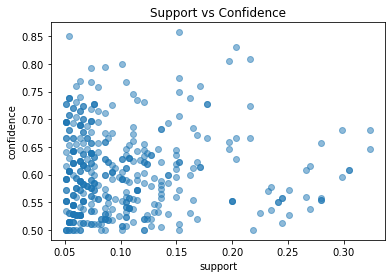

In [36]:
import matplotlib.pyplot as plt

plt.scatter(rules_ap['support'], rules_ap['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

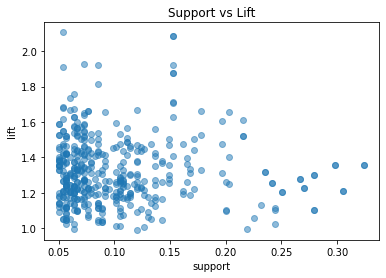

In [37]:
plt.scatter(rules_ap['support'], rules_ap['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

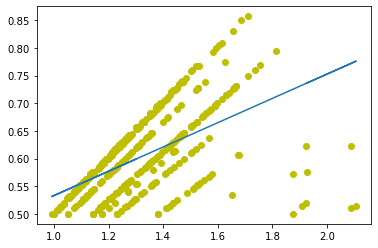

In [38]:
fit = np.polyfit(rules_ap['lift'], rules_ap['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules_ap['lift'], rules_ap['confidence'], 'yo', rules_ap['lift'], 
 fit_fn(rules_ap['lift']))

### Let's look at the maximal frequent itemset

In [41]:
from mlxtend.frequent_patterns import fpmax

fpmax(ohe_df, min_support=0.1, use_colnames = True)

,support,itemsets
0,0.158730,"(Pencil, Bagel)"
1,0.107937,"(Pencil, Cheese, Eggs)"
2,0.120635,"(Pencil, Eggs, Wine)"
3,0.104762,"(Pencil, Bread, Diaper)"
4,0.107937,"(Pencil, Diaper, Wine)"
5,0.101587,"(Pencil, Milk, Cheese)"
6,0.107937,"(Pencil, Milk, Bread)"
7,0.104762,"(Pencil, Cheese, Meat)"
8,0.111111,"(Pencil, Bread, Meat)"
9,0.114286,"(Pencil, Meat, Wine)"
